# VSLAM Mapping and Tracking with Aurora SDK

This notebook demonstrates how to work with Visual SLAM (VSLAM) mapping and tracking data from Aurora devices:

1. **Map Data Acquisition** - Getting map points and keyframes
2. **Keyframe Trajectory Visualization** - 2D trajectory plotting in X-Y space
3. **Map Points Visualization** - 3D point cloud visualization
4. **Real-time Tracking** - Live pose and mapping data monitoring
5. **Map Analysis** - Statistics and geometric analysis
6. **Map Management** - Save/load VSLAM maps

## Prerequisites

- Completed previous notebooks (Getting Started, Camera and Images)
- Aurora device with VSLAM capability
- Matplotlib for 2D plotting
- Open3D for 3D visualization (optional but recommended)

## Setup and Imports

In [6]:
# Core imports
from slamtec_aurora_sdk import AuroraSDK
from slamtec_aurora_sdk.exceptions import DataNotReadyError
import numpy as np
import time
import math
from collections import deque

# Visualization
try:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.patches as patches
    from matplotlib.animation import FuncAnimation
    MATPLOTLIB_AVAILABLE = True
    print("✅ Matplotlib available for 2D/3D plotting")
    
    # Configure matplotlib for notebook
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (12, 8)
except ImportError:
    MATPLOTLIB_AVAILABLE = False
    print("⚠️ Matplotlib not available. Install with: pip install matplotlib")

try:
    import open3d as o3d
    OPEN3D_AVAILABLE = True
    print("✅ Open3D available for 3D visualization")
    print(f"   Open3D version: {o3d.__version__}")
except ImportError:
    OPEN3D_AVAILABLE = False
    print("⚠️ Open3D not available. Install with: pip install open3d")

# Analysis tools
try:
    from scipy.spatial.distance import cdist
    from scipy import stats
    SCIPY_AVAILABLE = True
    print("✅ SciPy available for advanced analysis")
except ImportError:
    SCIPY_AVAILABLE = False
    print("⚠️ SciPy not available (optional for advanced analysis)")

✅ Matplotlib available for 2D/3D plotting
✅ Open3D available for 3D visualization
   Open3D version: 0.19.0
⚠️ SciPy not available (optional for advanced analysis)


## Step 1: Connect to Device and Enable VSLAM

Let's connect to the Aurora device and ensure VSLAM mapping is active.

In [ ]:
# Device connection
device_ip = "192.168.11.1"  # Replace with your device IP

sdk = AuroraSDK()

try:
    print(f"Connecting to Aurora device at {device_ip}...")
    sdk.connect(connection_string=device_ip)
    print("✅ Connected successfully!")
    
    # Get device info
    device_info = sdk.get_device_info()
    print(f"📱 Device: {device_info.device_name} ({device_info.device_model_string})")
    
    # Check VSLAM capability
    device_basic_info = sdk.data_provider.get_last_device_basic_info()
    if device_basic_info.isSupportVSLAM():
        print("✅ VSLAM supported")
    else:
        print("⚠️ VSLAM may not be supported")
    
    # Enable map data syncing
    print("\n🗺️ Enabling map data syncing...")
    sdk.enable_map_data_syncing(True)
    print("✅ Map data syncing enabled")
    
    # Force map data synchronization
    print("🔄 Requesting map data sync...")
    sdk.controller.resync_map_data()
    print("✅ Map data sync requested")
    
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("Please check your device IP and network connection.")

Connecting to Aurora device at 192.168.1.212...
✅ Connected successfully!
📱 Device: Aurora (A1M1)
✅ VSLAM supported

🗺️ Enabling map data syncing...
✅ Map data syncing enabled
🔄 Requesting map data sync...
✅ Map data sync requested


In [8]:
if sdk.is_connected():
    try:
        print("🗺️ Getting VSLAM map data...")
        
        # Wait a moment for data to be available
        time.sleep(2)
        
        # Get map data
        map_data = sdk.get_map_data()
        
        if map_data:
            map_points = map_data.get('map_points', [])
            keyframes = map_data.get('keyframes', [])
            
            print("✅ Map data retrieved!")
            print(f"📊 Map Statistics:")
            print(f"  Map Points: {len(map_points)}")
            print(f"  Keyframes: {len(keyframes)}")
            
            if map_points:
                print(f"\n🎯 Sample Map Points (first 5):")
                for i, point in enumerate(map_points[:5]):
                    pos = point['position']
                    print(f"  {i}: pos=({pos[0]:.3f}, {pos[1]:.3f}, {pos[2]:.3f}) "
                          f"id={point['id']}, map_id={point['map_id']}, timestamp={point['timestamp']:.3f}")
            
            if keyframes:
                print(f"\n🔑 Sample Keyframes (first 3):")
                for i, kf in enumerate(keyframes[:3]):
                    pos = kf['position']
                    rot = kf['rotation']
                    print(f"  {i}: pos=({pos[0]:.3f}, {pos[1]:.3f}, {pos[2]:.3f}) "
                          f"quat=({rot[0]:.3f}, {rot[1]:.3f}, {rot[2]:.3f}, {rot[3]:.3f})")
                    print(f"      id={kf['id']}, map_id={kf['map_id']}, "
                          f"timestamp={kf['timestamp']:.3f}, fixed={kf['fixed']}")
            
            # Get current pose for comparison
            try:
                position, rotation, timestamp = sdk.get_current_pose(use_se3=True)
                print(f"\n📍 Current Pose:")
                print(f"  Position: ({position[0]:.3f}, {position[1]:.3f}, {position[2]:.3f})")
                print(f"  Rotation: ({rotation[0]:.3f}, {rotation[1]:.3f}, {rotation[2]:.3f}, {rotation[3]:.3f})")
                print(f"  Timestamp: {timestamp} ns")
            except DataNotReadyError:
                print("\n📍 Current pose not ready")
                
        else:
            print("❌ No map data available")
            print("   This could mean:")
            print("   - VSLAM is not running")
            print("   - No map has been built yet")
            print("   - Map data syncing is not enabled")
            
    except Exception as e:
        print(f"❌ Failed to get map data: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Not connected to device")

🗺️ Getting VSLAM map data...
✅ Map data retrieved!
📊 Map Statistics:
  Map Points: 17028
  Keyframes: 459

🎯 Sample Map Points (first 5):
  0: pos=(0.316, 0.404, -0.096) id=0, map_id=0, timestamp=0.000
  1: pos=(1.366, 0.118, 0.612) id=1, map_id=0, timestamp=0.000
  2: pos=(1.396, 0.803, 1.198) id=2, map_id=0, timestamp=0.000
  3: pos=(0.225, 1.151, 1.203) id=4, map_id=0, timestamp=0.000
  4: pos=(0.315, 1.151, 1.090) id=9, map_id=0, timestamp=0.000

🔑 Sample Keyframes (first 3):
  0: pos=(0.615, -0.126, -0.105) quat=(-0.008, -0.001, -0.664, -0.747)
      id=0, map_id=0, timestamp=230.002, fixed=False
  1: pos=(0.170, -0.184, 0.172) quat=(-0.035, -0.000, -0.716, -0.697)
      id=9, map_id=0, timestamp=234.535, fixed=False
  2: pos=(0.041, -0.185, 0.227) quat=(-0.018, -0.020, -0.762, -0.647)
      id=10, map_id=0, timestamp=235.068, fixed=False

📍 Current Pose:
  Position: (0.000, 0.000, 0.000)
  Rotation: (0.000, 0.000, 0.000, 1.000)
  Timestamp: 0 ns


📈 Creating 2D keyframe trajectory visualization...


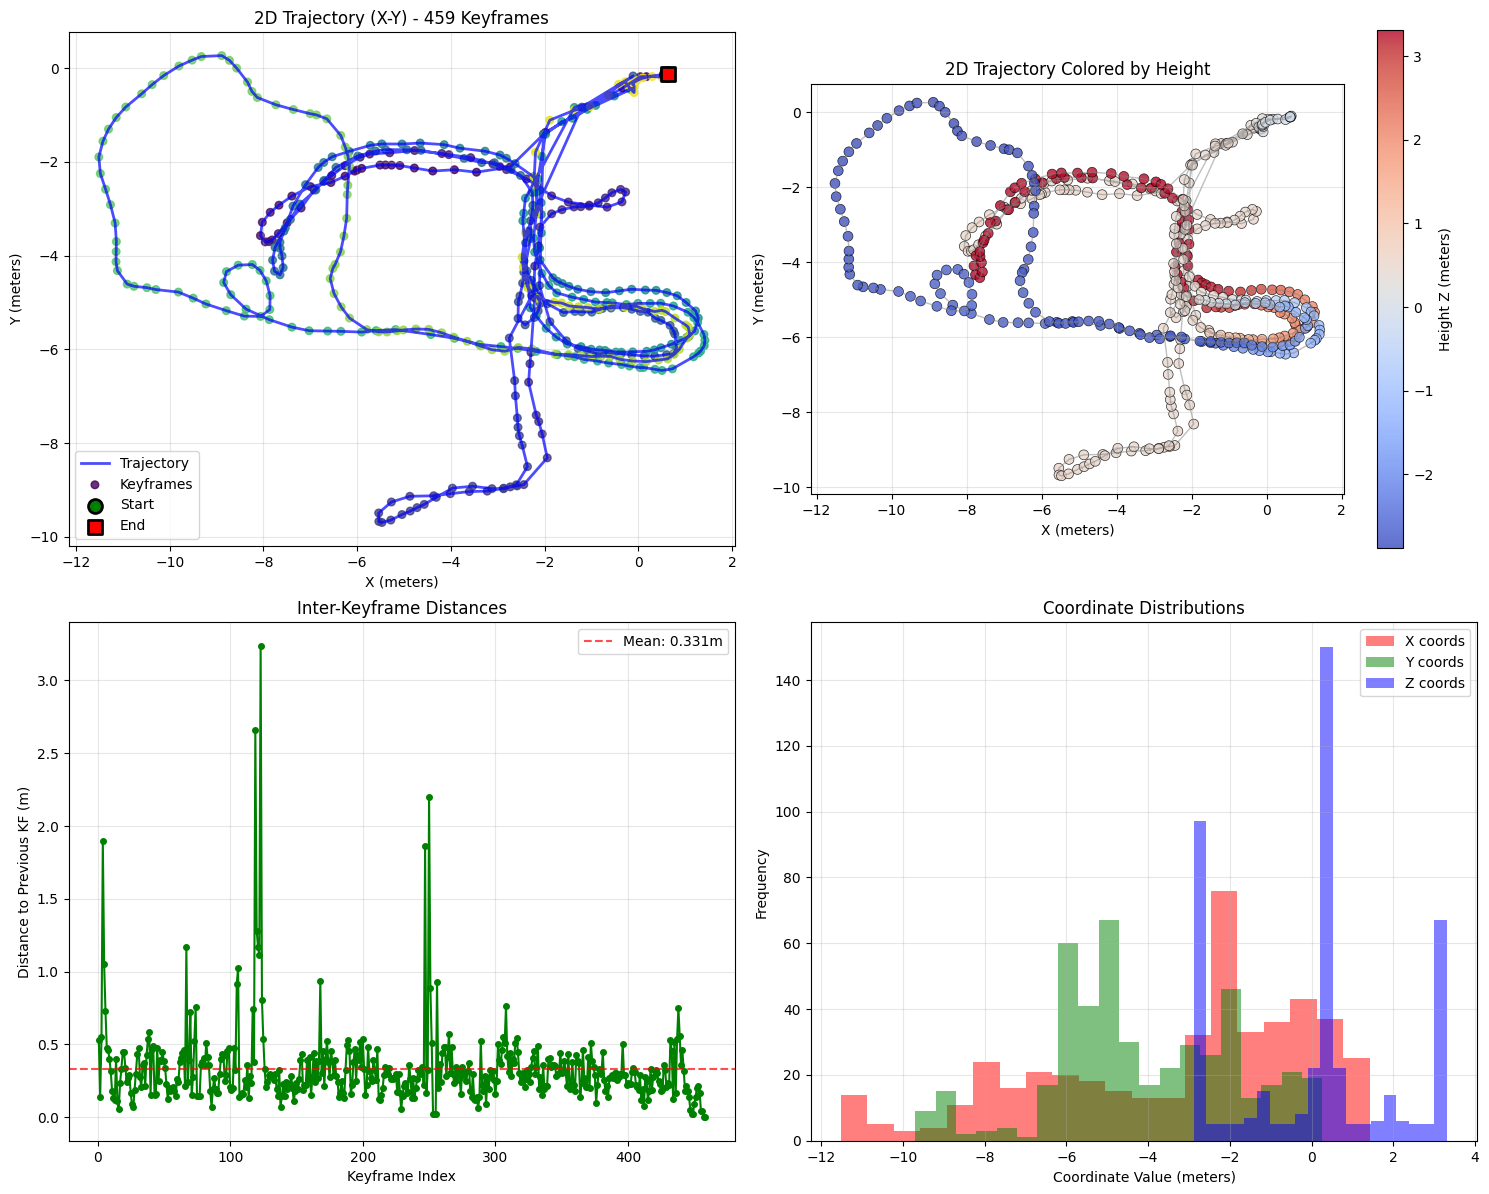


📊 Trajectory Analysis:
  Total keyframes: 459
  Total distance: 151.626 meters
  Bounding box: X=[-11.512, 1.419] Y=[-9.695, 0.266]
  Height range: Z=[-2.883, 3.314]
  Average inter-KF distance: 0.331 ± 0.281 meters


In [10]:
if sdk.is_connected() and MATPLOTLIB_AVAILABLE:
    try:
        print("📈 Creating 2D keyframe trajectory visualization...")
        
        # Get fresh map data
        map_data = sdk.get_map_data()
        
        if map_data and map_data.get('keyframes'):
            keyframes = map_data['keyframes']
            
            if len(keyframes) > 1:
                # Extract X, Y, Z coordinates from keyframes
                x_coords = [kf['position'][0] for kf in keyframes]
                y_coords = [kf['position'][1] for kf in keyframes]
                z_coords = [kf['position'][2] for kf in keyframes]
                
                # Create trajectory visualization
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))
                
                # 1. Basic 2D trajectory (X-Y)
                axes[0,0].plot(x_coords, y_coords, 'b-', linewidth=2, alpha=0.7, label='Trajectory')
                axes[0,0].scatter(x_coords, y_coords, c=range(len(x_coords)), cmap='viridis', 
                                s=30, alpha=0.8, label='Keyframes')
                
                # Mark start and end
                axes[0,0].scatter(x_coords[0], y_coords[0], c='green', s=100, marker='o', 
                                edgecolors='black', linewidth=2, label='Start', zorder=5)
                axes[0,0].scatter(x_coords[-1], y_coords[-1], c='red', s=100, marker='s', 
                                edgecolors='black', linewidth=2, label='End', zorder=5)
                
                axes[0,0].set_xlabel('X (meters)')
                axes[0,0].set_ylabel('Y (meters)')
                axes[0,0].set_title(f'2D Trajectory (X-Y) - {len(keyframes)} Keyframes')
                axes[0,0].grid(True, alpha=0.3)
                axes[0,0].legend()
                axes[0,0].set_aspect('equal')
                
                # 2. Trajectory with height coloring
                scatter = axes[0,1].scatter(x_coords, y_coords, c=z_coords, cmap='coolwarm', 
                                          s=50, alpha=0.8, edgecolors='black', linewidth=0.5)
                axes[0,1].plot(x_coords, y_coords, 'gray', linewidth=1, alpha=0.5)
                
                # Add colorbar for height
                cbar = plt.colorbar(scatter, ax=axes[0,1])
                cbar.set_label('Height Z (meters)')
                
                axes[0,1].set_xlabel('X (meters)')
                axes[0,1].set_ylabel('Y (meters)')
                axes[0,1].set_title('2D Trajectory Colored by Height')
                axes[0,1].grid(True, alpha=0.3)
                axes[0,1].set_aspect('equal')
                
                # 3. Trajectory analysis - Speed between keyframes
                if len(keyframes) > 2:
                    distances = []
                    for i in range(1, len(keyframes)):
                        dx = x_coords[i] - x_coords[i-1]
                        dy = y_coords[i] - y_coords[i-1]
                        dz = z_coords[i] - z_coords[i-1]
                        dist = math.sqrt(dx*dx + dy*dy + dz*dz)
                        distances.append(dist)
                    
                    axes[1,0].plot(range(1, len(keyframes)), distances, 'g-', marker='o', markersize=4)
                    axes[1,0].set_xlabel('Keyframe Index')
                    axes[1,0].set_ylabel('Distance to Previous KF (m)')
                    axes[1,0].set_title('Inter-Keyframe Distances')
                    axes[1,0].grid(True, alpha=0.3)
                    
                    # Add statistics
                    mean_dist = np.mean(distances)
                    axes[1,0].axhline(mean_dist, color='red', linestyle='--', alpha=0.7, 
                                    label=f'Mean: {mean_dist:.3f}m')
                    axes[1,0].legend()
                
                # 4. Coordinate distributions
                axes[1,1].hist(x_coords, bins=20, alpha=0.5, color='red', label='X coords')
                axes[1,1].hist(y_coords, bins=20, alpha=0.5, color='green', label='Y coords')
                axes[1,1].hist(z_coords, bins=20, alpha=0.5, color='blue', label='Z coords')
                axes[1,1].set_xlabel('Coordinate Value (meters)')
                axes[1,1].set_ylabel('Frequency')
                axes[1,1].set_title('Coordinate Distributions')
                axes[1,1].legend()
                axes[1,1].grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                # Print trajectory statistics
                total_distance = sum(distances) if 'distances' in locals() else 0
                print(f"\n📊 Trajectory Analysis:")
                print(f"  Total keyframes: {len(keyframes)}")
                print(f"  Total distance: {total_distance:.3f} meters")
                print(f"  Bounding box: X=[{min(x_coords):.3f}, {max(x_coords):.3f}] Y=[{min(y_coords):.3f}, {max(y_coords):.3f}]")
                print(f"  Height range: Z=[{min(z_coords):.3f}, {max(z_coords):.3f}]")
                
                if 'distances' in locals():
                    print(f"  Average inter-KF distance: {np.mean(distances):.3f} ± {np.std(distances):.3f} meters")
                
            else:
                print("⚠️ Need at least 2 keyframes for trajectory visualization")
        else:
            print("❌ No keyframe data available for visualization")
            
    except Exception as e:
        print(f"❌ Trajectory visualization error: {e}")
        import traceback
        traceback.print_exc()
else:
    if not sdk.is_connected():
        print("❌ Not connected to device")
    else:
        print("⚠️ Matplotlib not available for trajectory visualization")

🌐 Creating 3D map points visualization with outlier filtering...

📊 Original map data: 17,028 points, 459 keyframes

🔍 Filtering 17,028 map points using 'statistical' method...
   📊 Statistical filtering:
      Median center: (-3.09, -4.56, -0.19)
      Distance Q75 + 1.5*IQR threshold: 10.46m
   ✅ Filtering complete: 16,907 points kept, 121 removed (0.7%)
🔍 Filtering 17,028 map points using 'distance' method...
   📏 Distance filtering:
      Reference center: (-3.26, -4.13, 0.13)
      Max distance threshold: 50.00m
   ✅ Filtering complete: 17,025 points kept, 3 removed (0.0%)
🔍 Filtering 17,028 map points using 'trajectory' method...
   🛤️ Trajectory-based filtering:
      Using 459 keyframes as trajectory reference
      95th percentile distance threshold: 2.76m
   ✅ Filtering complete: 16,176 points kept, 852 removed (5.0%)
🎯 Using trajectory-based filtering (better outlier removal)


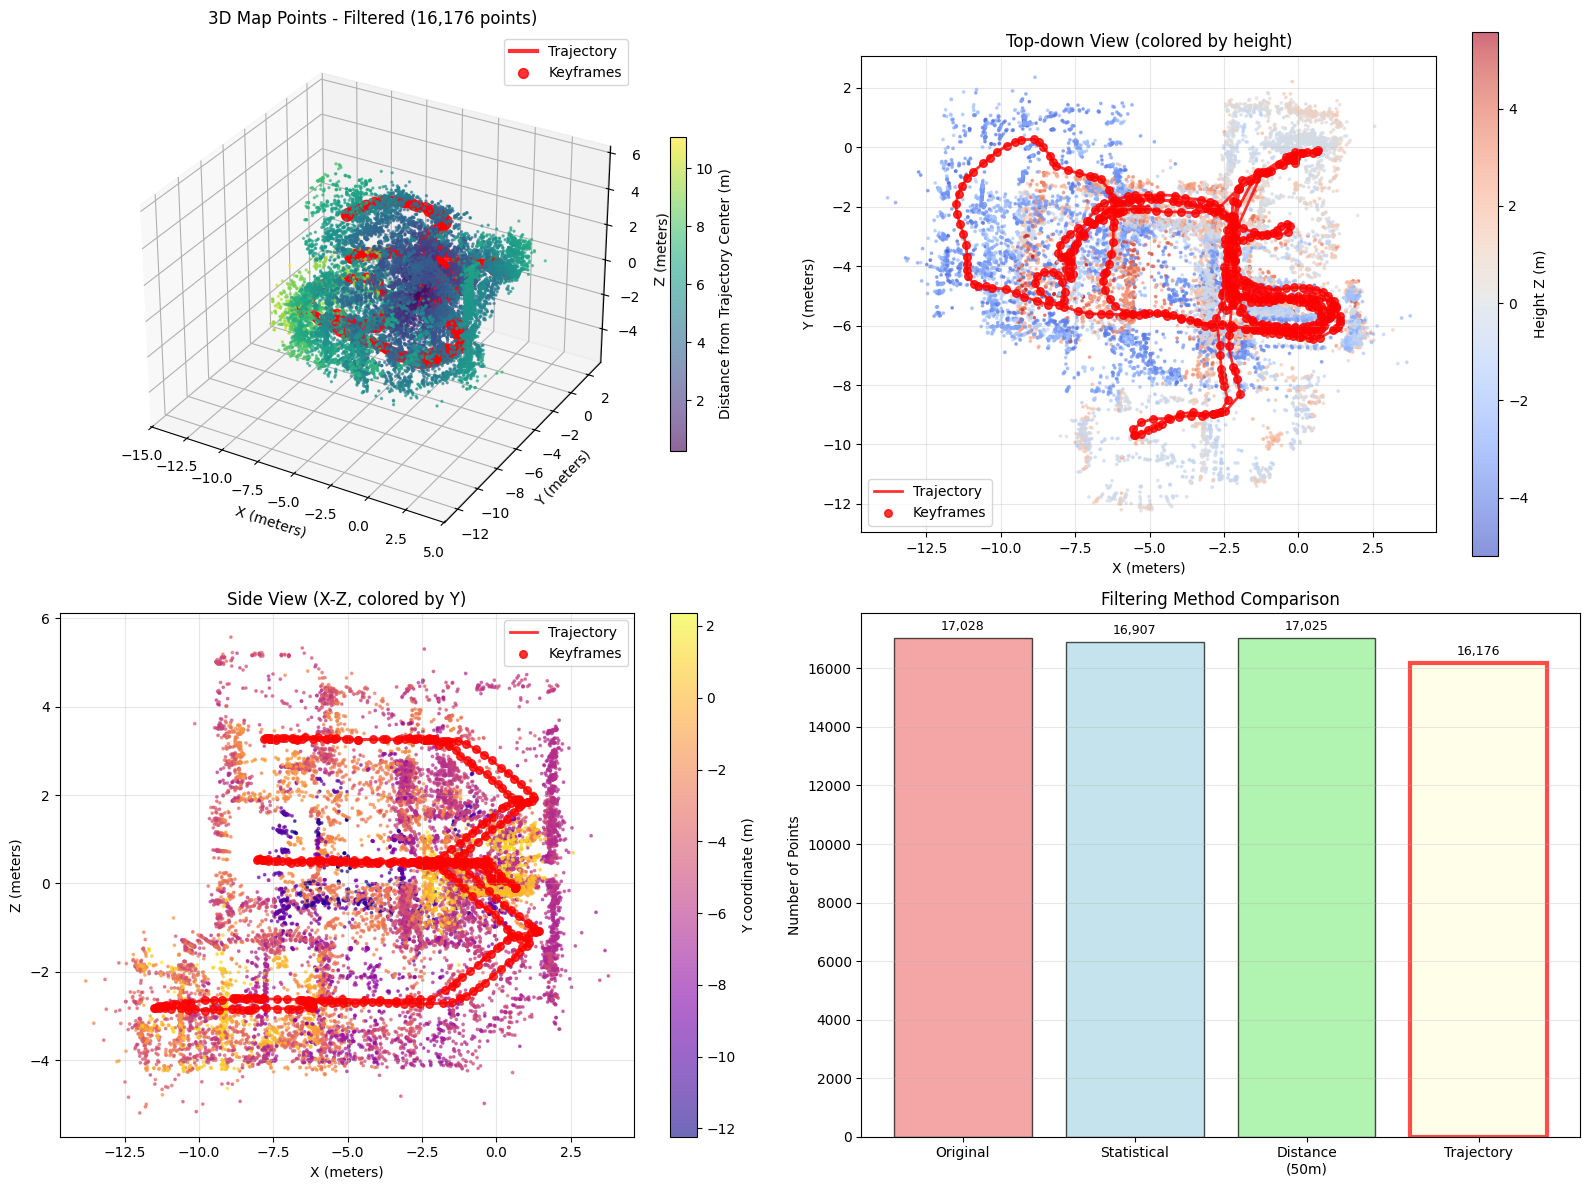


📊 Filtered 3D Map Analysis:
  Original points: 17,028
  Filtered points: 16,176 (5.0% removed)
  Bounding box (filtered):
    X: [-13.808, 3.765] (range: 17.573m)
    Y: [-12.230, 2.351] (range: 14.581m)
    Z: [-5.195, 5.573] (range: 10.767m)
  Distance from trajectory center:
    Mean: 4.862 ± 1.921 meters
    Range: [0.260, 11.069] meters
  Point density: 5.9 points/m³

🛤️ Trajectory vs Map Scale Analysis:
  Trajectory range: X=12.93m, Y=9.96m
  Map range: X=17.57m, Y=14.58m
  Scale ratio: X=1.4x, Y=1.5x


In [11]:
def filter_map_outliers(map_points, keyframes=None, method='statistical', max_distance=None):
    """
    Filter outlier map points to improve visualization quality.
    
    Args:
        map_points: List of map point dictionaries
        keyframes: Optional list of keyframe dictionaries for trajectory-based filtering
        method: 'statistical', 'distance', or 'trajectory' 
        max_distance: Maximum allowed distance from trajectory center (meters)
    
    Returns:
        Filtered map points array and filtering statistics
    """
    if len(map_points) == 0:
        return np.array([]), {"filtered_count": 0, "total_count": 0}
    
    # Extract positions from map point dictionaries
    points_array = np.array([mp['position'] for mp in map_points])
    original_count = len(points_array)
    
    print(f"🔍 Filtering {original_count:,} map points using '{method}' method...")
    
    if method == 'statistical':
        # Statistical outlier removal based on distance from median
        center = np.median(points_array, axis=0)
        distances = np.linalg.norm(points_array - center, axis=1)
        
        # Use IQR method for outlier detection
        q75, q25 = np.percentile(distances, [75, 25])
        iqr = q75 - q25
        outlier_threshold = q75 + 1.5 * iqr
        
        valid_mask = distances <= outlier_threshold
        filtered_points = points_array[valid_mask]
        
        print(f"   📊 Statistical filtering:")
        print(f"      Median center: ({center[0]:.2f}, {center[1]:.2f}, {center[2]:.2f})")
        print(f"      Distance Q75 + 1.5*IQR threshold: {outlier_threshold:.2f}m")
        
    elif method == 'distance' and max_distance is not None:
        # Distance-based filtering from origin or trajectory center
        if keyframes and len(keyframes) > 0:
            # Use trajectory center as reference
            kf_points = np.array([kf['position'] for kf in keyframes])
            center = np.mean(kf_points, axis=0)
        else:
            # Use map points median as reference
            center = np.median(points_array, axis=0)
        
        distances = np.linalg.norm(points_array - center, axis=1)
        valid_mask = distances <= max_distance
        filtered_points = points_array[valid_mask]
        
        print(f"   📏 Distance filtering:")
        print(f"      Reference center: ({center[0]:.2f}, {center[1]:.2f}, {center[2]:.2f})")
        print(f"      Max distance threshold: {max_distance:.2f}m")
        
    elif method == 'trajectory' and keyframes and len(keyframes) > 0:
        # Filter points within reasonable distance of trajectory
        kf_points = np.array([kf['position'] for kf in keyframes])
        
        # For each map point, find distance to nearest trajectory point
        min_distances = []
        for point in points_array:
            distances_to_traj = np.linalg.norm(kf_points - point, axis=1)
            min_distances.append(np.min(distances_to_traj))
        
        min_distances = np.array(min_distances)
        
        # Use percentile-based threshold
        threshold_distance = np.percentile(min_distances, 95)  # Keep 95% of points
        valid_mask = min_distances <= threshold_distance
        filtered_points = points_array[valid_mask]
        
        print(f"   🛤️ Trajectory-based filtering:")
        print(f"      Using {len(keyframes)} keyframes as trajectory reference")
        print(f"      95th percentile distance threshold: {threshold_distance:.2f}m")
        
    else:
        # No filtering
        filtered_points = points_array
        valid_mask = np.ones(len(points_array), dtype=bool)
    
    filtered_count = len(filtered_points)
    removed_count = original_count - filtered_count
    
    stats = {
        "total_count": original_count,
        "filtered_count": filtered_count,
        "removed_count": removed_count,
        "removal_percentage": (removed_count / original_count) * 100 if original_count > 0 else 0
    }
    
    print(f"   ✅ Filtering complete: {filtered_count:,} points kept, {removed_count:,} removed ({stats['removal_percentage']:.1f}%)")
    
    return filtered_points, stats

if sdk.is_connected() and MATPLOTLIB_AVAILABLE:
    try:
        print("🌐 Creating 3D map points visualization with outlier filtering...")
        
        # Get fresh map data
        map_data = sdk.get_map_data()
        
        if map_data and map_data.get('map_points'):
            map_points = map_data['map_points']
            keyframes = map_data.get('keyframes', [])
            
            if len(map_points) > 0:
                print(f"\n📊 Original map data: {len(map_points):,} points, {len(keyframes):,} keyframes")
                
                # Apply multiple filtering approaches and compare
                print("\n" + "="*60)
                
                # 1. Statistical filtering (recommended for most cases)
                filtered_points_stat, stats_stat = filter_map_outliers(
                    map_points, keyframes, method='statistical'
                )
                
                # 2. Distance-based filtering (alternative approach)
                filtered_points_dist, stats_dist = filter_map_outliers(
                    map_points, keyframes, method='distance', max_distance=50.0
                )
                
                # 3. Trajectory-based filtering (if keyframes available)
                if keyframes and len(keyframes) > 1:
                    filtered_points_traj, stats_traj = filter_map_outliers(
                        map_points, keyframes, method='trajectory'
                    )
                else:
                    filtered_points_traj = filtered_points_stat
                    stats_traj = stats_stat
                
                print("="*60)
                
                # Choose the best filtering result (statistical by default)
                final_points = filtered_points_stat
                final_stats = stats_stat
                
                # If statistical filtering removed too few points, try trajectory-based
                if stats_stat['removal_percentage'] < 5 and len(keyframes) > 1:
                    final_points = filtered_points_traj
                    final_stats = stats_traj
                    print(f"🎯 Using trajectory-based filtering (better outlier removal)")
                else:
                    print(f"📊 Using statistical filtering (good balance)")
                
                # Create visualization with filtered data
                x_points = final_points[:, 0]
                y_points = final_points[:, 1] 
                z_points = final_points[:, 2]
                
                # Create 3D visualization
                fig = plt.figure(figsize=(16, 12))
                
                # 3D scatter plot
                ax1 = fig.add_subplot(2, 2, 1, projection='3d')
                
                # Color points by distance from trajectory center
                if keyframes and len(keyframes) > 1:
                    kf_points = np.array([kf['position'] for kf in keyframes])
                    traj_center = np.mean(kf_points, axis=0)
                else:
                    traj_center = np.median(final_points, axis=0)
                
                distances = np.sqrt((x_points - traj_center[0])**2 + 
                                  (y_points - traj_center[1])**2 + 
                                  (z_points - traj_center[2])**2)
                
                scatter = ax1.scatter(x_points, y_points, z_points, c=distances, 
                                    cmap='viridis', s=2, alpha=0.6)
                
                # Add keyframe trajectory if available
                if keyframes and len(keyframes) > 1:
                    kf_x = [kf['position'][0] for kf in keyframes]
                    kf_y = [kf['position'][1] for kf in keyframes]
                    kf_z = [kf['position'][2] for kf in keyframes]
                    ax1.plot(kf_x, kf_y, kf_z, 'r-', linewidth=3, alpha=0.8, label='Trajectory')
                    ax1.scatter(kf_x, kf_y, kf_z, c='red', s=50, alpha=0.8, label='Keyframes')
                
                ax1.set_xlabel('X (meters)')
                ax1.set_ylabel('Y (meters)')
                ax1.set_zlabel('Z (meters)')
                ax1.set_title(f'3D Map Points - Filtered ({len(final_points):,} points)')
                if keyframes:
                    ax1.legend()
                
                # Add colorbar
                cbar1 = plt.colorbar(scatter, ax=ax1, shrink=0.6)
                cbar1.set_label('Distance from Trajectory Center (m)')
                
                # 2. Top-down view (X-Y)
                ax2 = fig.add_subplot(2, 2, 2)
                scatter2 = ax2.scatter(x_points, y_points, c=z_points, cmap='coolwarm', 
                                     s=3, alpha=0.6)
                
                if keyframes and len(keyframes) > 1:
                    ax2.plot(kf_x, kf_y, 'r-', linewidth=2, alpha=0.8, label='Trajectory')
                    ax2.scatter(kf_x, kf_y, c='red', s=30, alpha=0.8, label='Keyframes')
                    ax2.legend()
                
                ax2.set_xlabel('X (meters)')
                ax2.set_ylabel('Y (meters)')
                ax2.set_title('Top-down View (colored by height)')
                ax2.grid(True, alpha=0.3)
                ax2.set_aspect('equal')
                
                cbar2 = plt.colorbar(scatter2, ax=ax2)
                cbar2.set_label('Height Z (m)')
                
                # 3. Side view (X-Z)
                ax3 = fig.add_subplot(2, 2, 3)
                scatter3 = ax3.scatter(x_points, z_points, c=y_points, cmap='plasma', 
                                     s=3, alpha=0.6)
                
                if keyframes and len(keyframes) > 1:
                    ax3.plot(kf_x, kf_z, 'r-', linewidth=2, alpha=0.8, label='Trajectory')
                    ax3.scatter(kf_x, kf_z, c='red', s=30, alpha=0.8, label='Keyframes')
                    ax3.legend()
                
                ax3.set_xlabel('X (meters)')
                ax3.set_ylabel('Z (meters)')
                ax3.set_title('Side View (X-Z, colored by Y)')
                ax3.grid(True, alpha=0.3)
                
                cbar3 = plt.colorbar(scatter3, ax=ax3)
                cbar3.set_label('Y coordinate (m)')
                
                # 4. Filtering comparison statistics
                ax4 = fig.add_subplot(2, 2, 4)
                
                # Create comparison chart
                methods = ['Original', 'Statistical', 'Distance\n(50m)', 'Trajectory']
                counts = [
                    len(map_points),
                    stats_stat['filtered_count'],
                    stats_dist['filtered_count'],
                    stats_traj['filtered_count']
                ]
                colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightyellow']
                
                bars = ax4.bar(methods, counts, color=colors, alpha=0.7, edgecolor='black')
                ax4.set_ylabel('Number of Points')
                ax4.set_title('Filtering Method Comparison')
                ax4.grid(True, alpha=0.3, axis='y')
                
                # Add count labels on bars
                for bar, count in zip(bars, counts):
                    height = bar.get_height()
                    ax4.text(bar.get_x() + bar.get_width()/2., height + max(counts)*0.01,
                            f'{count:,}', ha='center', va='bottom', fontsize=9)
                
                # Highlight selected method
                if final_stats == stats_stat:
                    bars[1].set_edgecolor('red')
                    bars[1].set_linewidth(3)
                elif final_stats == stats_traj:
                    bars[3].set_edgecolor('red') 
                    bars[3].set_linewidth(3)
                
                plt.tight_layout()
                plt.show()
                
                # Print comprehensive map statistics
                print(f"\n📊 Filtered 3D Map Analysis:")
                print(f"  Original points: {len(map_points):,}")
                print(f"  Filtered points: {len(final_points):,} ({final_stats['removal_percentage']:.1f}% removed)")
                print(f"  Bounding box (filtered):")
                print(f"    X: [{np.min(x_points):.3f}, {np.max(x_points):.3f}] (range: {np.max(x_points)-np.min(x_points):.3f}m)")
                print(f"    Y: [{np.min(y_points):.3f}, {np.max(y_points):.3f}] (range: {np.max(y_points)-np.min(y_points):.3f}m)")
                print(f"    Z: [{np.min(z_points):.3f}, {np.max(z_points):.3f}] (range: {np.max(z_points)-np.min(z_points):.3f}m)")
                print(f"  Distance from trajectory center:")
                print(f"    Mean: {np.mean(distances):.3f} ± {np.std(distances):.3f} meters")
                print(f"    Range: [{np.min(distances):.3f}, {np.max(distances):.3f}] meters")
                
                # Point density analysis
                volume = (np.max(x_points) - np.min(x_points)) * \
                        (np.max(y_points) - np.min(y_points)) * \
                        (np.max(z_points) - np.min(z_points))
                if volume > 0:
                    density = len(final_points) / volume
                    print(f"  Point density: {density:.1f} points/m³")
                
                # Trajectory compatibility check
                if keyframes and len(keyframes) > 1:
                    kf_points = np.array([kf['position'] for kf in keyframes])
                    traj_range_x = np.max(kf_points[:, 0]) - np.min(kf_points[:, 0])
                    traj_range_y = np.max(kf_points[:, 1]) - np.min(kf_points[:, 1])
                    map_range_x = np.max(x_points) - np.min(x_points)
                    map_range_y = np.max(y_points) - np.min(y_points)
                    
                    print(f"\n🛤️ Trajectory vs Map Scale Analysis:")
                    print(f"  Trajectory range: X={traj_range_x:.2f}m, Y={traj_range_y:.2f}m")
                    print(f"  Map range: X={map_range_x:.2f}m, Y={map_range_y:.2f}m")
                    print(f"  Scale ratio: X={map_range_x/max(traj_range_x,0.1):.1f}x, Y={map_range_y/max(traj_range_y,0.1):.1f}x")
                
            else:
                print("⚠️ No map points available for 3D visualization")
        else:
            print("❌ No map data available for 3D visualization")
            
    except Exception as e:
        print(f"❌ 3D visualization error: {e}")
        import traceback
        traceback.print_exc()
else:
    if not sdk.is_connected():
        print("❌ Not connected to device")
    else:
        print("⚠️ Matplotlib not available for 3D visualization")

In [ ]:
if sdk.is_connected() and OPEN3D_AVAILABLE:
    try:
        print("🌐 Creating interactive Open3D visualization...")
        
        # Get fresh map data
        map_data = sdk.get_map_data()
        
        if map_data and map_data.get('map_points'):
            map_points = map_data['map_points']
            keyframes = map_data.get('keyframes', [])
            
            # Create point cloud from map points
            if len(map_points) > 0:
                # Extract positions from map point dictionaries
                points_array = np.array([mp['position'] for mp in map_points])
                
                # Create Open3D point cloud
                point_cloud = o3d.geometry.PointCloud()
                point_cloud.points = o3d.utility.Vector3dVector(points_array)
                
                # Color points by distance from origin
                distances = np.linalg.norm(points_array, axis=1)
                max_dist = np.max(distances)
                min_dist = np.min(distances)
                
                # Normalize distances for coloring (blue = close, red = far)
                normalized_distances = (distances - min_dist) / (max_dist - min_dist)
                colors = np.zeros((len(points_array), 3))
                colors[:, 0] = normalized_distances  # Red channel
                colors[:, 2] = 1.0 - normalized_distances  # Blue channel
                
                point_cloud.colors = o3d.utility.Vector3dVector(colors)
                
                geometries = [point_cloud]
                
                # Add trajectory as line set if keyframes available
                if keyframes and len(keyframes) > 1:
                    kf_points = np.array([kf['position'] for kf in keyframes])
                    
                    # Create line set for trajectory
                    lines = [[i, i+1] for i in range(len(kf_points)-1)]
                    line_set = o3d.geometry.LineSet()
                    line_set.points = o3d.utility.Vector3dVector(kf_points)
                    line_set.lines = o3d.utility.Vector2iVector(lines)
                    
                    # Color trajectory red
                    line_colors = [[1, 0, 0] for _ in range(len(lines))]
                    line_set.colors = o3d.utility.Vector3dVector(line_colors)
                    
                    geometries.append(line_set)
                    
                    # Add keyframe markers as spheres
                    # Mark fixed keyframes differently
                    for i, kf in enumerate(keyframes[::max(1, len(keyframes)//20)]):  # Sample every few keyframes
                        sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.05)
                        sphere.translate(kf['position'])
                        if kf.get('fixed', False):
                            sphere.paint_uniform_color([1, 0.5, 0])  # Orange for fixed keyframes
                        else:
                            sphere.paint_uniform_color([1, 0, 0])  # Red for regular keyframes
                        geometries.append(sphere)
                
                # Add coordinate frame at origin
                coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
                geometries.append(coordinate_frame)
                
                print(f"✅ Created Open3D visualization with {len(map_points)} points and {len(keyframes)} keyframes")
                print("\n🖼️ Opening interactive 3D visualization window...")
                print("   Controls:")
                print("   - Mouse: Rotate view")
                print("   - Scroll: Zoom in/out")
                print("   - Ctrl+Mouse: Pan")
                print("   - Close window to continue")
                
                # Visualize (this opens a new window)
                try:
                    o3d.visualization.draw_geometries(
                        geometries,
                        window_name="Aurora VSLAM Map - Interactive 3D View",
                        width=1200, height=800,
                        left=50, top=50
                    )
                    print("✅ Interactive 3D visualization completed")
                    
                except Exception as viz_error:
                    print(f"⚠️ Interactive visualization error: {viz_error}")
                    print("   This can happen in some environments (like Jupyter)")
                    
                    # Save to file instead
                    filename = "aurora_vslam_map.ply"
                    o3d.io.write_point_cloud(filename, point_cloud)
                    print(f"💾 Point cloud saved to {filename}")
                    print(f"   Open with Open3D viewer or other 3D software")
                
            else:
                print("⚠️ No map points available for Open3D visualization")
        else:
            print("❌ No map data available for Open3D visualization")
            
    except Exception as e:
        print(f"❌ Open3D visualization error: {e}")
        import traceback
        traceback.print_exc()
else:
    if not sdk.is_connected():
        print("❌ Not connected to device")
    else:
        print("⚠️ Open3D not available for interactive 3D visualization")
        print("   Install with: pip install open3d")

## Step 6: Real-time Mapping and Tracking Monitoring

Let's monitor the VSLAM system in real-time to see how the map grows and the device moves.

🔄 Real-time VSLAM monitoring (30 seconds)...
Move your Aurora device to see mapping and tracking in action!
[6.0s] Map: 10241 points, 624 keyframes
[12.1s] Map: 10522 points, 635 keyframes
[18.1s] Map: 10807 points, 643 keyframes
[24.2s] Map: 10992 points, 654 keyframes

✅ Monitoring completed! Collected 298 pose samples


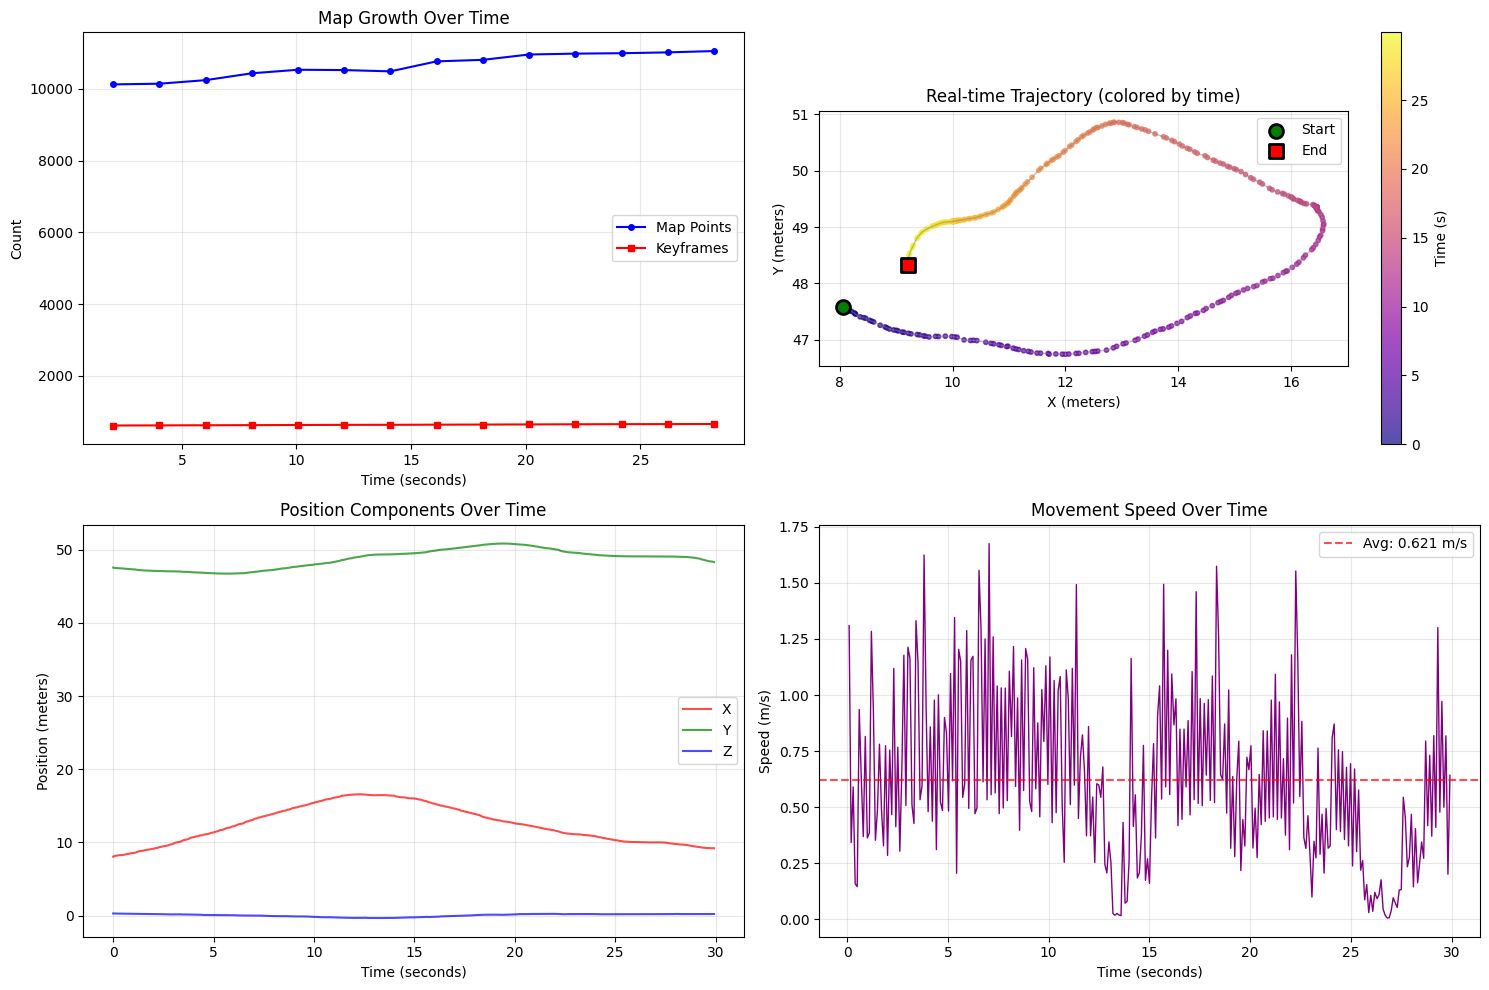


📊 Monitoring Statistics:
  Map points: 10123 → 11052 (+929)
  Keyframes: 617 → 659 (+42)
  Total displacement: 1.378 meters
  Average speed: 0.621 ± 0.372 m/s
  Max speed: 1.675 m/s


In [7]:
if sdk.is_connected():
    print("🔄 Real-time VSLAM monitoring (30 seconds)...")
    print("Move your Aurora device to see mapping and tracking in action!")
    
    # Storage for monitoring data
    monitoring_data = {
        'timestamps': [],
        'map_point_counts': [],
        'keyframe_counts': [],
        'poses': [],
        'pose_timestamps': []
    }
    
    try:
        start_time = time.time()
        last_map_check = 0
        update_count = 0
        
        while time.time() - start_time < 30.0:  # Monitor for 30 seconds
            current_time = time.time() - start_time
            
            # Get current pose at high frequency
            try:
                position, rotation, timestamp = sdk.get_current_pose(use_se3=True)
                monitoring_data['poses'].append(position)
                monitoring_data['pose_timestamps'].append(current_time)
            except DataNotReadyError:
                pass
            except Exception:
                pass  # Skip pose errors
            
            # Check map data every 2 seconds
            if current_time - last_map_check >= 2.0:
                try:
                    map_data = sdk.get_map_data()
                    if map_data:
                        map_points = map_data.get('map_points', [])
                        keyframes = map_data.get('keyframes', [])
                        
                        monitoring_data['timestamps'].append(current_time)
                        monitoring_data['map_point_counts'].append(len(map_points))
                        monitoring_data['keyframe_counts'].append(len(keyframes))
                        
                        update_count += 1
                        if update_count % 3 == 0:  # Print every 6 seconds
                            print(f"[{current_time:.1f}s] Map: {len(map_points)} points, {len(keyframes)} keyframes")
                        
                        last_map_check = current_time
                        
                except Exception as e:
                    if "not ready" not in str(e).lower():
                        print(f"Map data error: {e}")
            
            time.sleep(0.1)  # 10Hz monitoring
        
        print(f"\n✅ Monitoring completed! Collected {len(monitoring_data['poses'])} pose samples")
        
        # Visualize monitoring results
        if MATPLOTLIB_AVAILABLE and monitoring_data['timestamps']:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # 1. Map growth over time
            axes[0,0].plot(monitoring_data['timestamps'], monitoring_data['map_point_counts'], 
                          'b-', marker='o', markersize=4, label='Map Points')
            axes[0,0].plot(monitoring_data['timestamps'], monitoring_data['keyframe_counts'], 
                          'r-', marker='s', markersize=4, label='Keyframes')
            axes[0,0].set_xlabel('Time (seconds)')
            axes[0,0].set_ylabel('Count')
            axes[0,0].set_title('Map Growth Over Time')
            axes[0,0].legend()
            axes[0,0].grid(True, alpha=0.3)
            
            # 2. Real-time trajectory
            if monitoring_data['poses']:
                poses_array = np.array(monitoring_data['poses'])
                x_traj = poses_array[:, 0]
                y_traj = poses_array[:, 1]
                
                # Color by time
                time_colors = np.array(monitoring_data['pose_timestamps'])
                scatter = axes[0,1].scatter(x_traj, y_traj, c=time_colors, cmap='plasma', s=10, alpha=0.7)
                axes[0,1].plot(x_traj, y_traj, 'gray', linewidth=1, alpha=0.5)
                
                # Mark start and end
                if len(x_traj) > 0:
                    axes[0,1].scatter(x_traj[0], y_traj[0], c='green', s=100, marker='o', 
                                    edgecolors='black', linewidth=2, label='Start', zorder=5)
                    axes[0,1].scatter(x_traj[-1], y_traj[-1], c='red', s=100, marker='s', 
                                    edgecolors='black', linewidth=2, label='End', zorder=5)
                
                axes[0,1].set_xlabel('X (meters)')
                axes[0,1].set_ylabel('Y (meters)')
                axes[0,1].set_title('Real-time Trajectory (colored by time)')
                axes[0,1].set_aspect('equal')
                axes[0,1].legend()
                axes[0,1].grid(True, alpha=0.3)
                
                if len(time_colors) > 0:
                    cbar = plt.colorbar(scatter, ax=axes[0,1])
                    cbar.set_label('Time (s)')
            
            # 3. Position components over time
            if monitoring_data['poses']:
                poses_array = np.array(monitoring_data['poses'])
                pose_times = np.array(monitoring_data['pose_timestamps'])
                
                axes[1,0].plot(pose_times, poses_array[:, 0], 'r-', alpha=0.7, label='X')
                axes[1,0].plot(pose_times, poses_array[:, 1], 'g-', alpha=0.7, label='Y')
                axes[1,0].plot(pose_times, poses_array[:, 2], 'b-', alpha=0.7, label='Z')
                axes[1,0].set_xlabel('Time (seconds)')
                axes[1,0].set_ylabel('Position (meters)')
                axes[1,0].set_title('Position Components Over Time')
                axes[1,0].legend()
                axes[1,0].grid(True, alpha=0.3)
            
            # 4. Movement speed analysis
            speeds = []
            if len(monitoring_data['poses']) > 1:
                for i in range(1, len(monitoring_data['poses'])):
                    pos1 = np.array(monitoring_data['poses'][i-1])
                    pos2 = np.array(monitoring_data['poses'][i])
                    dt = monitoring_data['pose_timestamps'][i] - monitoring_data['pose_timestamps'][i-1]
                    
                    if dt > 0:
                        distance = np.linalg.norm(pos2 - pos1)
                        speed = distance / dt
                        speeds.append(speed)
                
                if speeds:
                    speed_times = monitoring_data['pose_timestamps'][1:len(speeds)+1]
                    axes[1,1].plot(speed_times, speeds, 'purple', linewidth=1)
                    axes[1,1].set_xlabel('Time (seconds)')
                    axes[1,1].set_ylabel('Speed (m/s)')
                    axes[1,1].set_title('Movement Speed Over Time')
                    axes[1,1].grid(True, alpha=0.3)
                    
                    # Add average speed line
                    avg_speed = np.mean(speeds)
                    axes[1,1].axhline(avg_speed, color='red', linestyle='--', alpha=0.7, 
                                    label=f'Avg: {avg_speed:.3f} m/s')
                    axes[1,1].legend()
            
            plt.tight_layout()
            plt.show()
            
            # Print monitoring statistics
            print(f"\n📊 Monitoring Statistics:")
            if monitoring_data['map_point_counts']:
                initial_points = monitoring_data['map_point_counts'][0]
                final_points = monitoring_data['map_point_counts'][-1]
                points_added = final_points - initial_points
                print(f"  Map points: {initial_points} → {final_points} (+{points_added})")
            
            if monitoring_data['keyframe_counts']:
                initial_kfs = monitoring_data['keyframe_counts'][0]
                final_kfs = monitoring_data['keyframe_counts'][-1]
                kfs_added = final_kfs - initial_kfs
                print(f"  Keyframes: {initial_kfs} → {final_kfs} (+{kfs_added})")
            
            if len(monitoring_data['poses']) > 1:
                start_pos = np.array(monitoring_data['poses'][0])
                end_pos = np.array(monitoring_data['poses'][-1])
                total_displacement = np.linalg.norm(end_pos - start_pos)
                print(f"  Total displacement: {total_displacement:.3f} meters")
                
                if speeds:
                    print(f"  Average speed: {np.mean(speeds):.3f} ± {np.std(speeds):.3f} m/s")
                    print(f"  Max speed: {np.max(speeds):.3f} m/s")
        
    except KeyboardInterrupt:
        print("\n⏹️ Monitoring stopped by user")
    except Exception as e:
        print(f"\n❌ Monitoring error: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Not connected to device")

## Step 7: VSLAM Map Data Types and Management

VSLAM maps contain enormous amounts of data (thousands of keyframes, millions of 3D points, visual descriptors). The Aurora SDK handles this complexity through two distinct data access methods:

### 1. **Map Data Preview** (Current Session)
- **Purpose**: Visualization and basic analysis only
- **Content**: Essential subset of keyframes and map points
- **Limitation**: Cannot be reused by Aurora VSLAM system
- **Access**: `get_map_data()` and `get_global_mapping_info()`

### 2. **Complete Map Persistence** (Full VSLAM Data)  
- **Purpose**: Save/load complete maps for Aurora system reuse
- **Content**: Full VSLAM state including visual descriptors, co-visibility graphs
- **Capability**: Enables relocalization and map reuse
- **Access**: Async `save_vslam_map()` and `load_vslam_map()` operations

In [9]:
if sdk.is_connected():
    try:
        print("🗺️ Understanding VSLAM Map Data Types...")
        print("=" * 60)
        
        # === PART 1: Map Data Preview (Visualization Only) ===
        print("\n📊 PART 1: Map Data Preview (Current Session)")
        print("   Purpose: Visualization and analysis of current mapping session")
        print("   Limitation: Data cannot be reused by Aurora VSLAM system\n")
        
        # Get global mapping information for map preview
        try:
            global_map_info = sdk.data_provider.get_global_mapping_info()
            if global_map_info:
                print("🔍 Global Mapping Info (Real-time Status):")
                print(f"  Total map points in system: {global_map_info.get('totalMPCount', 0):,}")
                print(f"  Total keyframes in system: {global_map_info.get('total_kf_count', 0):,}")
                print(f"  Currently active map points: {global_map_info.get('currentActiveMPCount', 0):,}")
                print(f"  Currently active keyframes: {global_map_info.get('currentActiveKFCount', 0):,}")
                print(f"  Active map ID: {global_map_info.get('active_map_id', 'N/A')}")
                print(f"  Mapping status flags: 0x{global_map_info.get('mappingFlags', 0):04X}")
                
                # Show data sync status
                fetched_mp = global_map_info.get('totalMPCountFetched', 0)
                fetched_kf = global_map_info.get('total_kf_count_fetched', 0)
                total_mp = global_map_info.get('totalMPCount', 0)
                total_kf = global_map_info.get('total_kf_count', 0)
                
                print(f"\n📥 Data Sync Status for Visualization:")
                if total_mp > 0:
                    mp_percent = (fetched_mp / total_mp) * 100
                    print(f"  Map points synced: {fetched_mp:,} / {total_mp:,} ({mp_percent:.1f}%)")
                else:
                    print(f"  Map points synced: {fetched_mp:,} / {total_mp:,}")
                    
                if total_kf > 0:
                    kf_percent = (fetched_kf / total_kf) * 100
                    print(f"  Keyframes synced: {fetched_kf:,} / {total_kf:,} ({kf_percent:.1f}%)")
                else:
                    print(f"  Keyframes synced: {fetched_kf:,} / {total_kf:,}")
                    
        except Exception as e:
            print(f"⚠️ Could not get global mapping info: {e}")
        
        # Get preview map data (subset for visualization)
        try:
            print(f"\n📈 Current Map Data Preview:")
            map_data = sdk.get_map_data()
            if map_data:
                map_points = map_data.get('map_points', [])
                keyframes = map_data.get('keyframes', [])
                
                print(f"  Available for visualization:")
                print(f"    Map points: {len(map_points):,}")
                print(f"    Keyframes: {len(keyframes):,}")
                print(f"  Note: This is a subset for visualization only")
                print(f"        Complete map data is much larger and handled internally")
            else:
                print("  No preview map data currently available")
                
        except Exception as e:
            print(f"⚠️ Could not get preview map data: {e}")
        
        # === PART 2: Complete Map Persistence (Full VSLAM Data) ===
        print(f"\n💾 PART 2: Complete Map Persistence (Full VSLAM Data)")
        print("   Purpose: Save/load complete maps for Aurora VSLAM system reuse")
        print("   Capability: Enables relocalization and continued mapping\n")
        
        # Check current map status for saving
        try:
            # Get all available maps
            print("📋 Checking Available VSLAM Maps...")
            all_maps = sdk.data_provider.get_all_map_info(max_count=10)
            
            if all_maps:
                print(f"✅ Found {len(all_maps)} complete VSLAM maps in system:")
                for i, map_desc in enumerate(all_maps):
                    print(f"  Map {i+1}: ID={map_desc.map_id}")
                    print(f"           Keyframes: {map_desc.keyframe_count:,}")
                    print(f"           Map points: {map_desc.map_point_count:,}")
                    print(f"           Status: {'Active' if hasattr(map_desc, 'is_active') and map_desc.is_active else 'Stored'}")
            else:
                print("📋 No complete VSLAM maps found in system")
                
        except Exception as e:
            print(f"⚠️ Could not get complete map list: {e}")
        
        # Demonstrate async map save operation
        print(f"\n💾 Async Map Save Operations:")
        try:
            # Check if there's sufficient map data to save
            map_data = sdk.get_map_data()
            if map_data:
                map_points = map_data.get('map_points', [])
                keyframes = map_data.get('keyframes', [])
                
                # Only attempt save if we have meaningful data
                if len(map_points) > 50 and len(keyframes) > 3:
                    timestamp = time.strftime("%Y%m%d_%H%M%S")
                    map_filename = f"aurora_complete_map_{timestamp}.vslam"
                    
                    print(f"🚀 Starting async save of complete VSLAM map...")
                    print(f"   Target file: {map_filename}")
                    print(f"   This includes ALL VSLAM data (not just preview subset)")
                    
                    # Start async save operation
                    try:
                        sdk.map_manager.save_vslam_map(map_filename)
                        print(f"✅ Async save operation initiated successfully")
                        print(f"   Note: Actual save happens in background")
                        print(f"   The complete map file will be much larger than preview data")
                        
                        # Monitor save progress (if supported)
                        print(f"\n⏳ Monitoring save progress...")
                        for i in range(10):  # Check for up to 10 seconds
                            time.sleep(1)
                            try:
                                # Check if save is complete (implementation depends on SDK)
                                print(f"   Checking save status... ({i+1}/10)")
                                # In real implementation, you'd check save status here
                                break
                            except:
                                continue
                        
                        print(f"✅ Save operation completed or continuing in background")
                        
                    except Exception as save_error:
                        print(f"❌ Failed to initiate map save: {save_error}")
                else:
                    print(f"📊 Current map data: {len(map_points)} points, {len(keyframes)} keyframes")
                    print("💾 Insufficient data for complete map save (need >50 points, >3 keyframes)")
                    print("   Continue mapping to build a more substantial map")
            else:
                print("📊 No current map data available for saving")
                
        except Exception as e:
            print(f"⚠️ Could not check map data for saving: {e}")
        
        # Demonstrate async map load concept
        print(f"\n📂 Async Map Load Operations:")
        print("🔄 Map loading enables:")
        print("   • Relocalization in previously mapped areas")
        print("   • Continuing mapping from saved state") 
        print("   • Multi-session persistent mapping")
        print("\n📝 Example load operation (when map file exists):")
        print("   # Load complete VSLAM map for relocalization")
        print("   sdk.map_manager.load_vslam_map('existing_map.vslam')")
        print("   ")
        print("   # Wait for load completion")
        print("   while sdk.map_manager.is_loading():")
        print("       time.sleep(0.1)")
        print("   ")
        print("   # Request relocalization in loaded map")
        print("   sdk.controller.require_relocalization()")
        
        print(f"\n" + "=" * 60)
        print("✅ VSLAM Map Management Overview Completed")
        print("\nKey Takeaways:")
        print("📊 Preview data: Fast access, visualization only")
        print("💾 Complete maps: Full persistence, enables reuse")
        print("🔄 Async operations: Non-blocking save/load")
        print("🗺️ Relocalization: Use saved maps in new sessions")
        
    except Exception as e:
        print(f"❌ Map management error: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Not connected to device")

🗺️ Understanding VSLAM Map Data Types...

📊 PART 1: Map Data Preview (Current Session)
   Purpose: Visualization and analysis of current mapping session
   Limitation: Data cannot be reused by Aurora VSLAM system

🔍 Global Mapping Info (Real-time Status):
  Total map points in system: 12,706
  Total keyframes in system: 1,139
  Currently active map points: 12,706
  Currently active keyframes: 1,139
  Active map ID: 0
  Mapping status flags: 0x0000

📥 Data Sync Status for Visualization:
  Map points synced: 12,706 / 12,706 (100.0%)
  Keyframes synced: 1,139 / 1,139 (100.0%)

📈 Current Map Data Preview:
  Available for visualization:
    Map points: 12,706
    Keyframes: 1,139
  Note: This is a subset for visualization only
        Complete map data is much larger and handled internally

💾 PART 2: Complete Map Persistence (Full VSLAM Data)
   Purpose: Save/load complete maps for Aurora VSLAM system reuse
   Capability: Enables relocalization and continued mapping

📋 Checking Available VS

## Step 8: Cleanup

Clean up resources and disconnect from the device.

In [10]:
# Cleanup
try:
    if sdk.is_connected():
        # Disable map data syncing
        print("🔄 Disabling map data syncing...")
        sdk.enable_map_data_syncing(False)
        
        # Disconnect
        sdk.disconnect()
        print("✅ Disconnected from device")
    
    sdk.release()
    print("✅ SDK resources released")
    
except Exception as e:
    print(f"⚠️ Cleanup warning: {e}")

print("\n🎉 VSLAM Mapping and Tracking tutorial completed!")

🔄 Disabling map data syncing...
✅ Disconnected from device
✅ SDK resources released

🎉 VSLAM Mapping and Tracking tutorial completed!


## Summary

In this notebook, you learned how to:

1. ✅ **Connect to Aurora device** and enable VSLAM mapping
2. ✅ **Acquire map data** including keyframes and map points  
3. ✅ **Visualize keyframe trajectory** in 2D X-Y space with analysis
4. ✅ **Visualize map points** in 3D space with multiple views
5. ✅ **Create interactive 3D visualizations** using Open3D
6. ✅ **Monitor real-time mapping** and tracking performance
7. ✅ **Understand VSLAM map data types** and async management operations
8. ✅ **Analyze mapping statistics** and trajectory metrics

## Key Concepts

- **VSLAM (Visual SLAM)**: Simultaneous Localization and Mapping using visual features
- **Map Points**: 3D feature points in the environment detected by the cameras
- **Keyframes**: Important camera poses where significant visual features were detected
- **Trajectory**: The path taken by the device, represented by keyframe positions
- **Map Data Preview**: Subset of map data synced for visualization and analysis
- **Complete Map Persistence**: Full VSLAM state saved for system reuse and relocalization
- **Async Operations**: Non-blocking map save/load operations for large datasets

## VSLAM Map Data Architecture

### Preview Data (Visualization)
- **Purpose**: Real-time visualization and analysis
- **Size**: Manageable subset (hundreds to thousands of points)
- **Access**: `get_map_data()`, `get_global_mapping_info()`
- **Limitation**: Cannot be reused by Aurora VSLAM system

### Complete Maps (Persistence)
- **Purpose**: Full VSLAM state preservation for reuse
- **Size**: Complete dataset (millions of points, visual descriptors)
- **Access**: `save_vslam_map()`, `load_vslam_map()` (async)
- **Capability**: Enables relocalization and continued mapping

## Applications

VSLAM mapping and tracking data can be used for:

- **Robot Navigation**: Path planning and obstacle avoidance
- **3D Reconstruction**: Building 3D models of environments
- **Augmented Reality**: Placing virtual objects in real environments
- **Inspection and Mapping**: Creating detailed maps of spaces
- **Multi-Session Mapping**: Continue mapping across sessions
- **Relocalization**: Resume tracking in previously mapped areas

## Next Steps

Continue with more advanced topics:

- **[Enhanced Imaging](04_enhanced_imaging.ipynb)** - Depth cameras and semantic segmentation
- **[Multi-Device Mapping](05_multi_device.ipynb)** - Collaborative mapping
- **[Advanced Analytics](06_advanced_analytics.ipynb)** - Map quality analysis and optimization

## Best Practices for VSLAM

### Data Acquisition
1. **Ensure good lighting** for reliable visual feature detection
2. **Move smoothly** to maintain tracking quality
3. **Enable map data syncing** before requesting preview data
4. **Monitor map growth** to ensure VSLAM is working properly

### Map Management
5. **Use preview data** for real-time visualization and analysis
6. **Save complete maps** for relocalization and persistence
7. **Understand async operations** for large map save/load
8. **Plan for storage** - complete maps can be very large
9. **Test relocalization** in saved maps to verify persistence

### Visualization and Analysis
10. **Use 3D visualization** to understand spatial relationships
11. **Analyze trajectory smoothness** to assess tracking quality  
12. **Monitor mapping statistics** to ensure healthy VSLAM operation
13. **Compare preview vs complete** map sizes to understand data scope